# Diffusion maps on the angles

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
from jax.config import config
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pickle

from manifold_learning.diffusion_maps import compute_distance_matrix, compute_embedding
from manifold_learning.utils import plot_two_matrices, compute_density

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

#### Read the files

In [3]:
data_dir = "../data/two_views/"

(180, 200, 4)


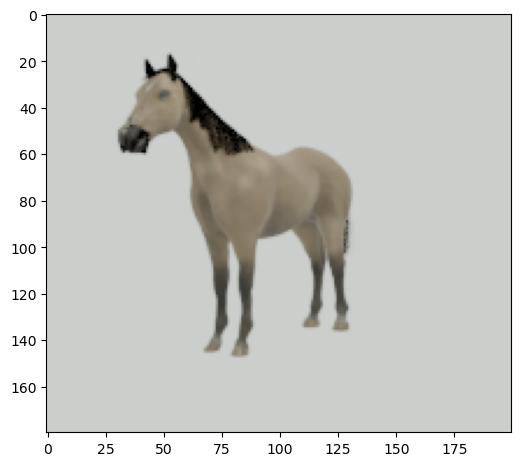

In [4]:
img_index = 150
img = np.array(Image.open(f"{data_dir}/horse_view1_{img_index}.png"))
print(img.shape)
plt.imshow(img[:, :, :3])

In [5]:
# Read the angles
with open(f"{data_dir}/angles.pkl", "rb") as file:
    angles = pickle.load(file)
angles = jnp.array(angles)

### Write each angle as a complex number with modulus 1 and compute distances

In [6]:
N = len(angles)
X = jnp.array([[jnp.cos(ang) + jnp.sin(ang) * 1j for ang in angles]])
A = compute_distance_matrix(X)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1756.13it/s]


#### Compute the manifold embedding

In [7]:
eps = 0.01

coords, w, v, W, L = compute_embedding(A, eps)

#### First take a look at the DM intermediate steps to make sure all is good

In [8]:
# How many neighbours are 'similar' to each point in the similarity matrix?
# Looking at the point in the 'center' of the list of points

ww = W[N // 2]
print(len(ww[ww > 0.1]))

49


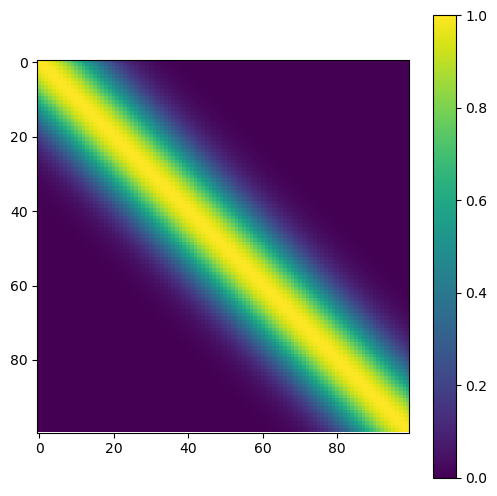

In [9]:
# Plot the similarity matrices, pre-normalization
plt.imshow(W[:100, :100])
plt.colorbar()

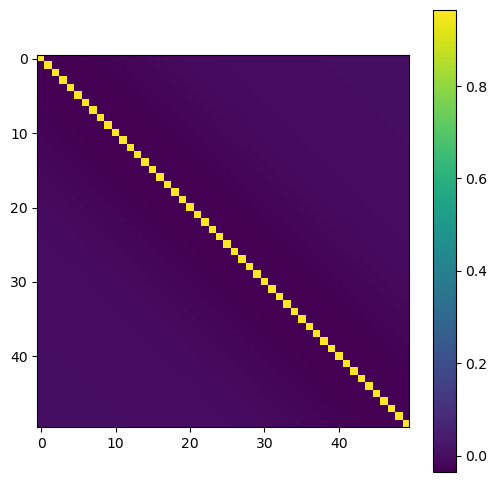

In [10]:
# Plot the final graph Laplacians
plt.imshow(L[:50, :50])
plt.colorbar()

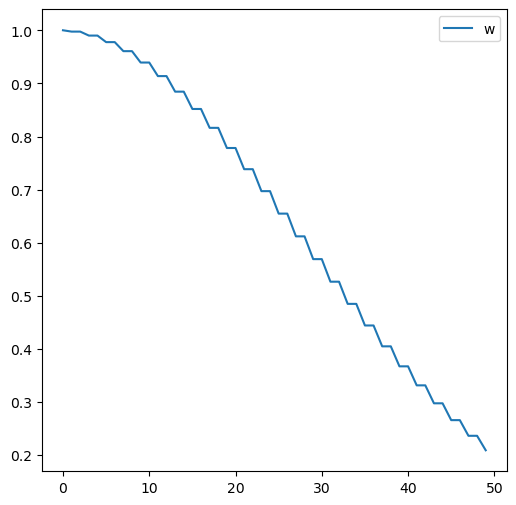

In [11]:
# Plot a few eigenvalues too

plt.plot(w[:50])

plt.legend(["w"])

In [12]:
print(w[:10])

[1.         0.99749686 0.99749686 0.99002503 0.99002503 0.97769636
 0.97769636 0.96069414 0.96069414 0.93926859]


#### And plot the actual embedding coordinates

In [13]:
savefig = False

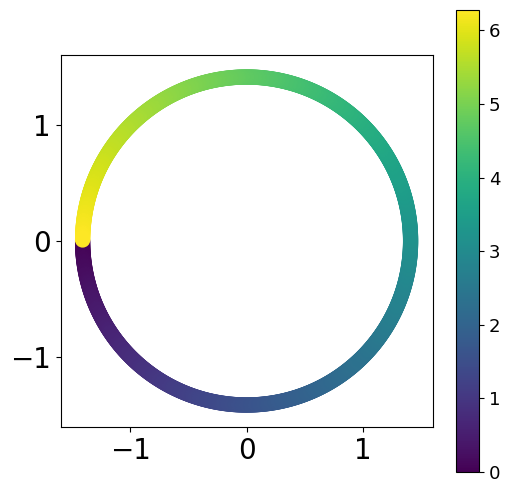

In [14]:
idx1 = 1
idx2 = 2
axis_scale = 1.6
equal_aspect = True

plt.rcParams["figure.figsize"] = 6, 6

fig, ax = plt.subplots(subplot_kw={"aspect": 1})

plt.scatter(coords[:, idx1], coords[:, idx2], c=angles, s=100)
cbar = plt.colorbar()

# plt.label(['stuff'])
if equal_aspect:
    plt.xlim(np.array([-1, 1]) * axis_scale)
    plt.ylim(np.array([-1, 1]) * axis_scale)

ax.tick_params(axis="both", which="major", labelsize=20)
cbar.ax.tick_params(labelsize=13)

if savefig:
    plt.savefig("embed_simulated_angles.eps")

#### True angles

In [15]:
angles = jnp.array(angles)

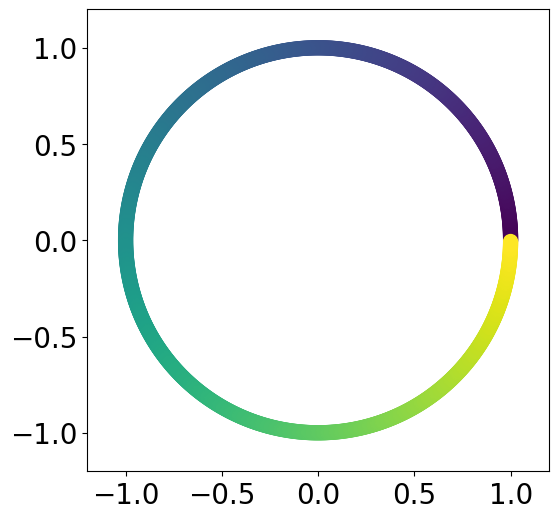

In [16]:
axis_scale = 1.2
equal_aspect = True
fig, ax = plt.subplots(subplot_kw={"aspect": 1})

plt.scatter(jnp.cos(angles), jnp.sin(angles), c=angles, s=100)

if equal_aspect:
    plt.xlim(np.array([-1, 1]) * axis_scale)
    plt.ylim(np.array([-1, 1]) * axis_scale)

ax.tick_params(axis="both", which="major", labelsize=20)

plt.rcParams["figure.figsize"] = 6, 6

# if savefig:
#    plt.savefig("simulated_true_angles.eps")

### Density

In [17]:
emb = coords[:, 1:3]

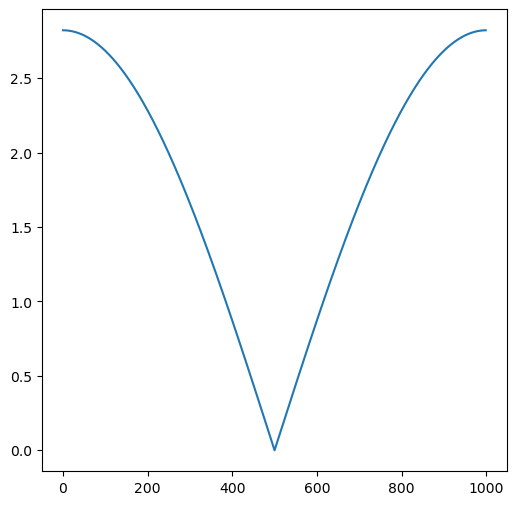

In [18]:
# Plot the distances between coordinates to set r
dists_i = jax.vmap(lambda pt0, pti: jnp.linalg.norm(pt0 - pti), in_axes=(None, 0))(
    emb[500], emb
)
plt.plot(dists_i)

In [19]:
r = 0.05

density = compute_density(emb, r)

In [20]:
# For better plotting, sort based on density and then plot the points in that order
idx_sorted_density = jnp.argsort(density)

In [21]:
savefig = False

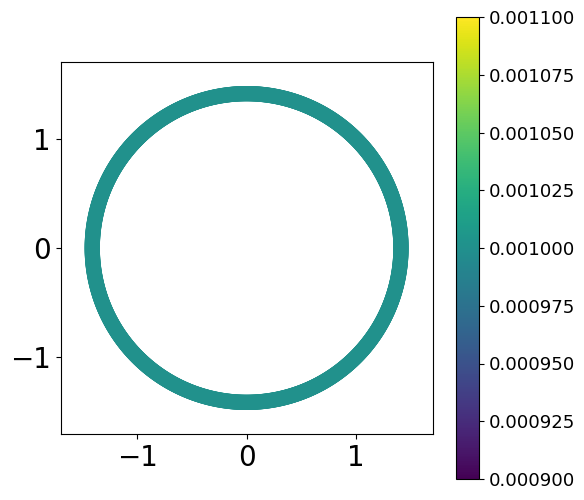

In [22]:
axis_scale = 1.7
equal_aspect = True

plt.rcParams["figure.figsize"] = 6, 6

fig, ax = plt.subplots(subplot_kw={"aspect": 1})

plt.scatter(
    emb[idx_sorted_density, 0],
    emb[idx_sorted_density, 1],
    c=density[idx_sorted_density],
    s=100,
    cmap="viridis",
)  # , vmin=0.0005, vmax=0.0030)
cbar = plt.colorbar()

if equal_aspect:
    plt.xlim(np.array([-1, 1]) * axis_scale)
    plt.ylim(np.array([-1, 1]) * axis_scale)

ax.tick_params(axis="both", which="major", labelsize=20)
cbar.ax.tick_params(labelsize=13)

if savefig:
    plt.savefig(f"embed_density_simulated_angles_r{r}.eps")